# Imports

In [1]:
import sys
sys.path.append("../common/")

import pandas as pd
import numpy as np
import statsmodels as sm
from datetime import datetime

from statsmodels.regression.linear_model import OLS
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

import psycopg
from utility import describe_table, SECRETS, CONNECTION_STRING

# Plot data

## Preprocessing

In [2]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

{'nasdaq_ohlc': None,
 'bitcoin_ohlc': None,
 'snp_ohlc': None,
 'dow_jones_ohlc': None,
 'gold_ohlc': None,
 'oil_price': None}

In [3]:
# can't handle oil
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            SELECT
                bucket::date,
                avg(close) AS avg_close
            FROM (
                SELECT
                    {dt_selector},
                    time_bucket('1 month'::INTERVAL, {dt_selector}) AS bucket,
                    close
                FROM "{asset}"
            )
            GROUP BY bucket
            ORDER BY bucket;
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data.sort_index()

In [4]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        SELECT
            bucket::date,
            avg(price) AS avg_price
        FROM (
            SELECT
                time_bucket('1 month'::INTERVAL, dt) AS bucket,
                price
            FROM oil_price
        )
        GROUP BY bucket
        ORDER BY bucket;
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data.sort_index()

In [5]:
price_data = pd.concat(
    assets.values(),
    axis="columns"
)[:"2025-07-01"]
price_data

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-01-01,2267.774722,NaN,1123.581582,10471.235300,1116.826300,78.325789
2010-02-01,2194.440006,NaN,1089.159989,10214.506271,1098.189479,76.387368
2010-03-01,2362.243896,NaN,1152.048690,10677.518767,1114.356525,81.203478
2010-04-01,2475.720017,NaN,1197.316185,11052.147647,1151.452375,84.292857
2010-05-01,2319.239001,NaN,1125.062006,10500.127002,1203.955005,73.743500
...,...,...,...,...,...,...
2025-03-01,17828.026507,85034.729655,5683.983352,42092.128720,2986.409528,68.239048
2025-04-01,16678.459728,86303.044444,5369.495722,39876.327753,3211.152367,63.536667
2025-05-01,18642.369234,103348.610215,5810.919480,41864.245350,3280.738095,62.167619


In [6]:
first_values = price_data.dropna(axis="rows").iloc[0]
first_values

nasdaq_ohlc        2743.795007
bitcoin_ohlc          6.260668
snp_ohlc           1300.578015
dow_jones_ohlc    12550.986523
gold_ohlc          1660.195001
oil_price           100.273500
Name: 2012-01-01 00:00:00, dtype: float64

In [7]:
norm_data = price_data / first_values

## Plotting

In [8]:
style_frame = pd.DataFrame(
    {
        "alias": ["bitcoin_ohlc", "nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price"],
        "asset_name": ["Bitcoin", "NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
        "color": ["#ff0000", "#0092BC", "#2F4F4F", "#62250B", "#E88F09", "#000000"],
        "style": ["solid"] * 6,
        "alpha": [1] * 6,
        "size": [2] * 6,
        "text_offset": [0, 0.15, 0.1, -0.05, -0.05, 0]
    }
)
style_frame = style_frame.set_index("alias")
style_frame

,asset_name,color,style,alpha,size,text_offset
alias,,,,,,
bitcoin_ohlc,Bitcoin,#ff0000,solid,1,2,0.00
nasdaq_ohlc,NASDAQ,#0092BC,solid,1,2,0.15
snp_ohlc,S&P 500,#2F4F4F,solid,1,2,0.10
dow_jones_ohlc,Dow Jones,#62250B,solid,1,2,-0.05
gold_ohlc,Gold,#E88F09,solid,1,2,-0.05
oil_price,Oil,#000000,solid,1,2,0.00


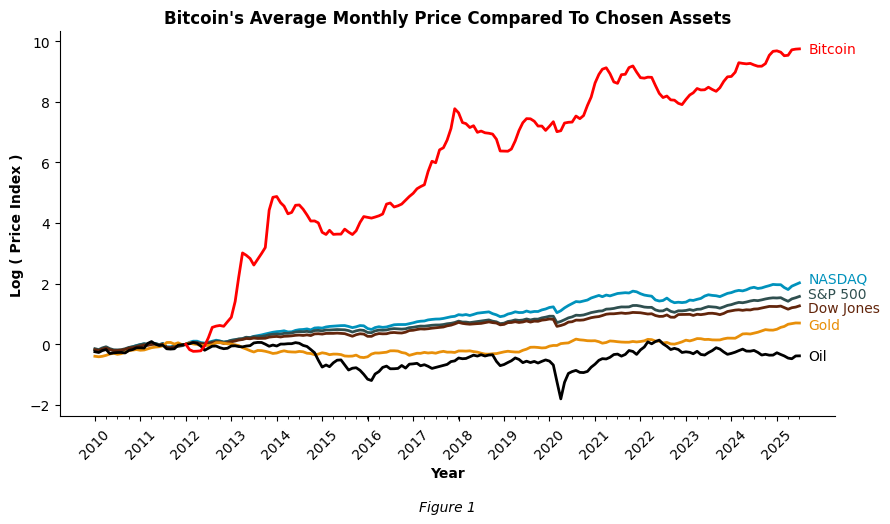

In [9]:
from math import log

# Global >>>
bg_color = "#FFFFFF"

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(
    "Bitcoin's Average Monthly Price Compared To Chosen Assets",
    weight="bold"
)
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
# <<<

# Plotting >>>
new_index_order = ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]
iter_data = norm_data.map(log).reindex(columns=new_index_order).items()
for name, asset in iter_data:
    style = style_frame.loc[name]
    ax.plot(
        asset,
        label=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"],
        linewidth=style["size"],
        linestyle=style["style"]
    )

    ax.text(
        x=asset.index[-1] + pd.offsets.Day(70),
        y=asset.iloc[-1] - 0.15 + style["text_offset"],
        s=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"]
    )
# <<<

# X-axis >>>
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.set_xticks(
    pd.date_range(start="2010-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
ax.set_xticklabels(np.arange(2010,2026))

arr = norm_data.index.to_numpy()
quarters = pd.date_range(start=arr[0],end=arr[-1], freq="QE-DEC").to_numpy()
ax.set_xticks(quarters, minor=True)

ax.set_xlabel(
    "Year",
    weight="bold",
)

ax.text(
    x=(ax.get_xlim()[1] + ax.get_xlim()[0]) / 2,
    y=-5.5,
    s="Figure 1",
    ha="center",
    style="italic"
)
# <<<

# Y-axis >>>
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    "Log ( Price Index )",
    weight="bold"
)
# <<<
pass

## Summary

* The data presented on the chart is normalized w.r.t. to (average) price of each asset in January 2012 and logarithimed. This was done for 2 reasons:
    * Differences in prices in 2012 and subsequent years and 
    * due to enourmous growth of Bitcoin in the last decade.
* Interpretation of the chart:
$$ROI_{k;t} := P_{k;t} - 1$$

$$d_{m;n} := ln(P_{m;n})$$

$$ROI_{k;t} = \frac{P_{0;t}}{P_{0;k}} - 1$$

$$ROI_{k;t} =  \frac{e^{d_{0;t}}}{e^{d_{0;k}}} - 1$$

$$ROI_{k;t} =  e^{d_{0;t}-d_{0;k}} - 1$$

Where each point on the chart is $(x; y) = (x; d_{2012;x})$\
* Thus, the interpretation is: $ ROI_{k;t} =  e^{y_t - y_k} - 1$
* This is however a relatively complex interpretation. The main goal of the chart is to compare price developments of Bitcoin and other chosen assets in appropriate manner 
* Coming at 1,702,630.84% (I) growth over the last ~13 years period Bitcoin's returns shadow any asset in a similar timeframe.
* Such comparisons are however very naive since Bitcoin was founded in 2009, which makes it, in the grand scheme of things, a brand new investment tool
* Remarkably, Bitcoin's growth has been very stable across the years resulting in ~5,38% a month. While other assets have experiences more stable growth rates (II) of about ~1% a month, they once again did not come close to Bitcoin's return
* It's needless to say, that past returns do not gurantee future growth especially amidst increased global uncertainty and regulation

* We will consider "real" returns (as in inflation-free) later in our analysis

### I

In [ ]:
((data.iloc[-1] / first_values - 1) * 100).round(2).astype(str) + "%"

### II

In [ ]:
subset = data.reset_index(drop=True).map(log)
subset["const"] = 1
subset["X"] = np.arange(1,len(subset)+1)
subset

In [ ]:
for asset in ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]:
    frame = subset[["const","X",asset]]
    frame = frame.dropna(axis="rows")
    
    res = OLS(
        exog=frame[["const","X"]].to_numpy(),
        endog=frame[asset].dropna().to_numpy(),
        hasconst=True
    ).fit()
    
    print(
        res.summary(
            yname=f"Log price",
            xname=["Constant", "Month"],
            title=f"{asset} summary",
            alpha=0.01,
            slim=True
        ),
        end="\n\n\n"
    )

# Calculate CV

## Preprocessing

In [10]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

{'nasdaq_ohlc': None,
 'bitcoin_ohlc': None,
 'snp_ohlc': None,
 'dow_jones_ohlc': None,
 'gold_ohlc': None,
 'oil_price': None}

In [11]:
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            SELECT
            	time_bucket('1 year'::interval, {dt_selector}) as bucket,
            	stddev_samp(close) / avg(close) as cv
            FROM {asset}
            group by bucket;
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data

In [12]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        SELECT
            time_bucket('1 year'::interval, dt) as bucket,
            stddev_samp(price) / avg(price) as cv
        FROM oil_price
        group by bucket;
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data

In [13]:
cv_data = pd.concat(assets.values(), axis=1)[:"2025-07-01"]
cv_data

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-01-01,0.062928,NaN,0.049301,0.043082,0.080499,0.066088
2011-01-01,0.045995,NaN,0.049345,0.041012,0.093802,0.085146
2012-01-01,0.038007,0.379583,0.033803,0.024634,0.038191,0.082165
2013-01-01,0.086735,1.292875,0.060369,0.047684,0.104004,0.055740
2014-01-01,0.048461,0.273089,0.041326,0.032943,0.040102,0.145383
2015-01-01,0.031845,0.216284,0.026630,0.031539,0.049242,0.140324
2016-01-01,0.059546,0.242342,0.048422,0.052588,0.057992,0.155680
2017-01-01,0.063189,0.997283,0.044677,0.060781,0.027190,0.077210
2018-01-01,0.049964,0.320137,0.036563,0.033095,0.042714,0.100107


In [16]:
# Bitcoin False due to handling of NA values
(cv_data >= 0).all(axis="rows")

nasdaq_ohlc        True
bitcoin_ohlc      False
snp_ohlc           True
dow_jones_ohlc     True
gold_ohlc          True
oil_price          True
dtype: bool

In [17]:
# After dropping NA values the >= 0 condition holds
(cv_data["bitcoin_ohlc"].dropna() >= 0).all(axis="rows")

np.True_

## Plotting

In [21]:
style_frame = pd.DataFrame(
    {
        "alias": ["bitcoin_ohlc", "nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price"],
        "asset_name": ["Bitcoin", "NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
        "color": ["#ff0000", "#0092BC", "#2F4F4F", "#62250B", "#E88F09", "#000000"],
        "style": ["solid"] * 6,
        "alpha": [1] + [0.2] * 5,
        "size": [2] * 6,
        "text_offset_x": [0, 350, 0, 0, 0, 220],
        "text_offset_y": 0
    }
)
style_frame = style_frame.set_index("alias")
style_frame

,asset_name,color,style,alpha,size,text_offset_x,text_offset_y
alias,,,,,,,
bitcoin_ohlc,Bitcoin,#ff0000,solid,1.0,2,0,0
nasdaq_ohlc,NASDAQ,#0092BC,solid,0.2,2,350,0
snp_ohlc,S&P 500,#2F4F4F,solid,0.2,2,0,0
dow_jones_ohlc,Dow Jones,#62250B,solid,0.2,2,0,0
gold_ohlc,Gold,#E88F09,solid,0.2,2,0,0
oil_price,Oil,#000000,solid,0.2,2,220,0


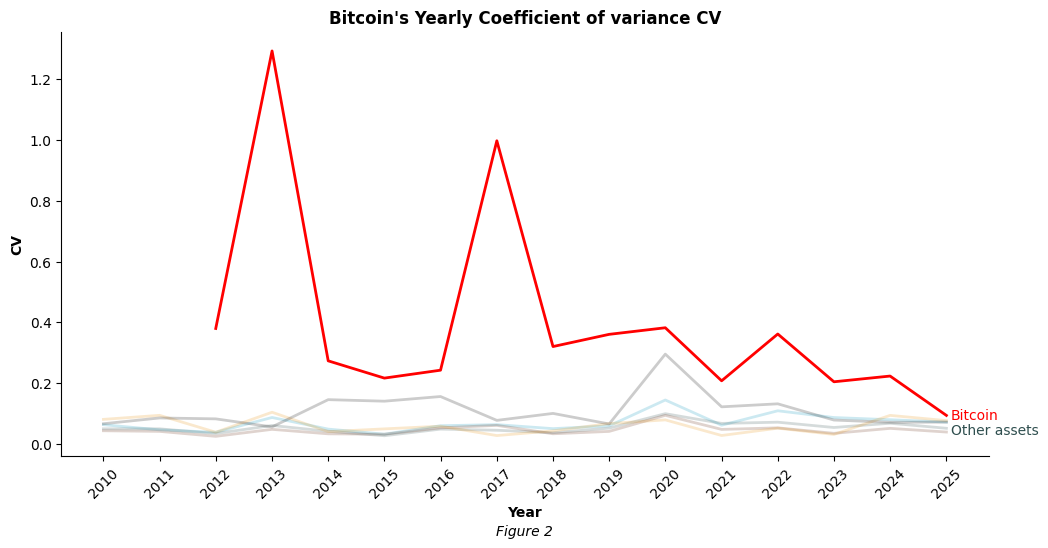

In [50]:
from math import log

# Global >>>
bg_color = "#FFFFFF"

fig, ax = plt.subplots(
    figsize=(10,5),
)
ax.set_title(
    "Bitcoin's Yearly Coefficient of variance CV",
    weight="bold"
)
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
fig.tight_layout()
# <<<

# Plotting >>>
new_index_order = ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]
iter_data = (cv_data
    #.map(log)
    .reindex(columns=new_index_order)
    .items()
    )
for name, asset in iter_data:
    style = style_frame.loc[name]
    ax.plot(
        asset,
        label=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"],
        linewidth=style["size"],
        linestyle=style["style"]
    )

ax.text(
    x=cv_data.index[-1] + pd.offsets.Day(30),
    y=cv_data.iloc[-1,1],
    s=style_frame.loc["bitcoin_ohlc", "asset_name"],
    color=style_frame.loc["bitcoin_ohlc", "color"],
    alpha=style_frame.loc["bitcoin_ohlc", "alpha"],
    va="center",
    ha="left"
)

ax.text(
    x=cv_data.index[-1] + pd.offsets.Day(30),
    y=cv_data.iloc[-1,1] - 0.05,
    s="Other assets",
    color=style_frame.loc["snp_ohlc", "color"],
    alpha=1,
    va="center",
    ha="left"
)
# <<<

# X-axis >>>
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.set_xticks(
    pd.date_range(start="2010-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
ax.set_xticklabels(np.arange(2010,2026))

ax.set_xlabel(
    "Year",
    weight="bold",
)

ax.text(
    x=(ax.get_xlim()[1] + ax.get_xlim()[0]) / 2,
    y=-0.3,
    s="Figure 2",
    ha="center",
    style="italic"
)
# <<<

# Y-axis >>>
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    "CV",
    weight="bold"
)
# <<<
pass

## Summary

* The figure show development of log coefficient of variance CV of assets over time
$$CV_i = \frac{\sigma_i}{\mu_i} $$
* This metric has been used in order to enable standartized and comparable analysis

* As Bitcoin's market cap grew, volatility fell. This makes sense since the market became more heterogenous and thus less correlated
* Having said that however Bitcoin remains highly volatile in absolute and relative terms
* Possible reason being speculativity

# Correlation

In [51]:
corr_matrix = price_data.corr().rename(
    columns={"nasdaq_ohlc":"NASDAQ", "bitcoin_ohlc":"Bitcoin", "snp_ohlc":"S&P 500", "dow_jones_ohlc":"Dow Jones", "gold_ohlc":"Gold", "oil_price":"Oil"},
    index={"nasdaq_ohlc":"NASDAQ", "bitcoin_ohlc":"Bitcoin", "snp_ohlc":"S&P 500", "dow_jones_ohlc":"Dow Jones", "gold_ohlc":"Gold", "oil_price":"Oil"}
)
corr_matrix

,NASDAQ,Bitcoin,S&P 500,Dow Jones,Gold,Oil
NASDAQ,1.000000,0.925308,0.994683,0.984261,0.807565,-0.125105
Bitcoin,0.925308,1.000000,0.922733,0.883168,0.900249,0.100957
S&P 500,0.994683,0.922733,1.000000,0.992190,0.796598,-0.121418
Dow Jones,0.984261,0.883168,0.992190,1.000000,0.747327,-0.153134
Gold,0.807565,0.900249,0.796598,0.747327,1.000000,0.130199
Oil,-0.125105,0.100957,-0.121418,-0.153134,0.130199,1.000000


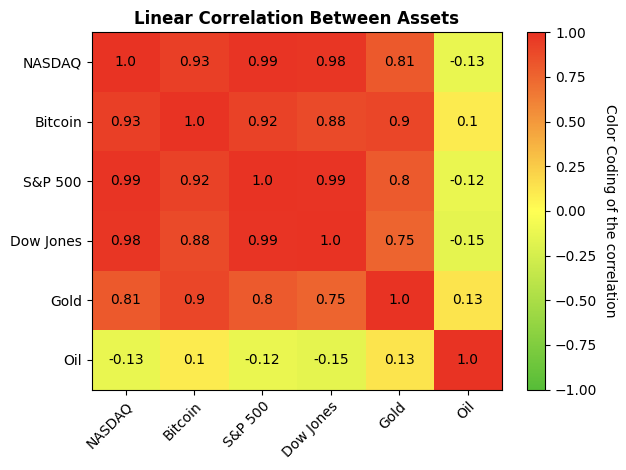

In [52]:
# source https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
index = corr_matrix.index
columns = corr_matrix.columns

matrix = corr_matrix.to_numpy().round(2)

cmap = LinearSegmentedColormap.from_list(
    "custom_redgreen",
    [
        (0.00, (0.34, 0.74, 0.22)),   # green at -1
        (0.50, (1, 1, 0.33)),  # yellow at  0
        (1.00, (0.91, 0.2, 0.14)),  # red at +1
    ]
)
norm = Normalize(vmin=-1, vmax=1)

fig, ax = plt.subplots()
im = ax.imshow(
    matrix,
    cmap=cmap,
    norm=norm,
    aspect="auto"
)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(columns)), labels=columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(index)), labels=index)

# Loop over data dimensions and create text annotations.
for i in range(len(index)):
    for j in range(len(columns)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="black")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap=cmap)
cbar.ax.set_ylabel("Color Coding of the correlation", rotation=-90, va="bottom")

ax.set_title("Linear correlation between assets".title(), weight="bold")
fig.tight_layout()